In [785]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.polynomial.legendre as leg

Set up classes

In [786]:
class flux:
    def __init__(self):
        self.moments = np.zeros((2,10))

In [787]:
class fission:
    def __init__(self):
        fission.k = 1
        fission.source = np.ones(10)

In [788]:
class material:
    def __init__(self, nuSigmaF, SigmaS, SigmaR, D, fL, fR):
        self.nuSigmaF = nuSigmaF
        self.SigmaS = SigmaS
        self.SigmaR = SigmaR
        self.D = D
        self.fL = fL
        self.fR = fR

In [789]:
class cell:
    def __init__(self, left, right, material):
        self.left = left
        self.right = right
        self.material = material

In [790]:
class mesh:
    def __init__(self, dx):
        self.dx = dx

In [791]:
class lhs:
    def __init__(self):
        self.thermal = None
        self.fast = None

In [792]:
class functions:
    def __init__(self):
        self.left_thermal = None
        self.right_thermal = None
        self.left_fast = None
        self.left_fast = None

Set up functions

In [793]:
def pi_rate(new, old):
    rate = np.amax(abs(new - old))
    return rate

In [794]:
def pi_convergence(new, old, new_pi_rate, old_pi_rate):
    # convergence criteria
    epi = 1e-5
    
    # calculate convergence rate
    rho = new_pi_rate / old_pi_rate

    if np.amax(abs(new - old)) < epi * (1 - rho):
        return True
    else:
        return False

In [795]:
def k_rate(new, old):
    rate = abs(new - old)
    return rate

In [796]:
def k_convergence(new, old, new_k_rate, old_k_rate):
    # convergence criteria
    ek = 1e-5

    # calculate convergence rate
    rho = new_k_rate / old_k_rate

    if abs(new - old) < ek * (1 - rho):
        return True
    else:
        return False

In [797]:
def build_lhs():
    # energy groups
    for g in range(2):
        # read in data
        d1 = node1.material.D[g]
        d2 = node2.material.D[g]
        dx = mesh1.dx
        fr1 = node1.material.fR[g]
        fl2 = node2.material.fL[g]
        SigmaR1 = node1.material.SigmaR[g]
        SigmaR2 = node2.material.SigmaR[g]

        # build matrix
        matrix = np.zeros((10,10))
        matrix[0,:] = [0, 1, -3, 6, -10, 0, 0, 0, 0, 0]
        matrix[1,:] = [0, 0, 0, 0, 0, 0,1, 3, 6, 10]
        matrix[2,:] = [0, d1/dx, 3*d1/dx, 6*d1/dx, 10*d1/dx, 0, -d2/ dx, 3*d2/dx, -6*d2/dx, 10*d2/dx]
        matrix[3,:] = [fr1, fr1, fr1, fr1, fr1, -fl2, fl2, -fl2, fl2, -fl2]
        matrix[4,:] = [SigmaR1, 0, -12*d1/(dx*dx), 0, -40*d1/(dx*dx), 0, 0, 0, 0, 0]
        matrix[5,:] = [0, 0, 0, 0, 0, SigmaR2, 0, -12*d2/(dx*dx), 0, -40*d2/(dx*dx)]
        matrix[6,:] = [0, SigmaR1, 0, -60*d1/(dx*dx), 0, 0, 0, 0, 0, 0]
        matrix[7,:] = [0, 0, 0, 0, 0, 0, SigmaR2, 0, -60*d2/(dx*dx), 0]
        matrix[8,:] = [0, 0, SigmaR1, 0, -140*d1/(dx*dx), 0, 0, 0, 0, 0]
        matrix[9,:] = [0, 0, 0, 0, 0, 0, 0, SigmaR2, 0, -140*d2/(dx*dx)]

        # assign to class
        if g == 0:
            lhs.fast = matrix.copy()
        if g == 1:
            lhs.thermal = matrix.copy()

In [798]:
def build_rhs(g):
    if g == 0: # fast
        k = fission.k
        source = fission.source
        F10 = source[0]
        F20 = source[5]
        F11 = source[1]
        F21 = source[6]
        F12 = source[2]
        F22 = source[7]
        
        rhs = np.array((0, 0, 0, 0, 1/k * F10, 1/k * F20, 1/k * F11, 1/k * F21, 1/k * F12, 1/k * F22))
    if g == 1: # thermal
        SigmaS = node1.material.SigmaS[1]
        f110 = flux.moments[0,0]
        f120 = flux.moments[0,5]
        f111 = flux.moments[0,1]
        f121 = flux.moments[0,6]
        f112 = flux.moments[0,2]
        f122 = flux.moments[0,7]
    
        rhs =  np.array((0, 0, 0, 0, SigmaS * f110,  SigmaS * f120, SigmaS * f111, SigmaS * f121, SigmaS * f112, SigmaS * f122))
    return rhs

In [799]:
def solve(g, lhs, rhs):
    flux.moments[g,:] = np.linalg.solve(lhs, rhs)

In [800]:
def calculate_fission_source():
    # get flux values
    fast_flux = flux.moments[0,:]
    thermal_flux = flux.moments[1,:]

    # node 1
    nuSigmaF1 = node1.material.nuSigmaF[1]
    nuSigmaF2 = node1.material.nuSigmaF[0]
    for j in range(5): # node 1
        fission.source[j] = nuSigmaF1 * fast_flux[j] + nuSigmaF2 * thermal_flux[j]

    # node 2
    nuSigmaF1 = node2.material.nuSigmaF[1]
    nuSigmaF2 = node2.material.nuSigmaF[0]
    for j in range(5,10): 
        fission.source[j] = nuSigmaF1 * fast_flux[j] + nuSigmaF2 * thermal_flux[j]
        
    first_coef = np.array((fission.source[0], fission.source[5]))
    return first_coef

In [801]:
def calculate_k(k_old, f_new, f_old):
    dx = mesh1.dx
    k_new = k_old * (f_new[0]*dx + f_new[1]*dx)/(f_old[0]*dx + f_old[1]*dx)
    fission.k = k_new
    return k_new

In [802]:
def calculate_flux_functions():
    fast_moments = flux.moments[0,:]
    thermal_moments = flux.moments[1,:]
    functions.left_thermal = leg.Legendre((thermal_moments[0], thermal_moments[1], thermal_moments[2], thermal_moments[3], thermal_moments[4]), domain=(0,10))
    functions.right_thermal = leg.Legendre((thermal_moments[5], thermal_moments[6], thermal_moments[7], thermal_moments[8], thermal_moments[9]), domain=(10,20))
    functions.left_fast = leg.Legendre((fast_moments[0], fast_moments[1], fast_moments[2], fast_moments[3], fast_moments[4]), domain=(0,10))
    functions.right_fast = leg.Legendre((fast_moments[5], fast_moments[6], fast_moments[7], fast_moments[8], fast_moments[9]), domain=(10,20))

Main loops

In [803]:
def power_iteration():
    iter = 100
    k_old = 1
    flux_old = flux.moments.copy()
    f_old = fission.source.copy()
    old_pi_rate = 1
    old_k_rate = 1

    for i in range(iter):
        # iterate through energy groups
        for g in range(2):
            if g == 0:
                lhs_matrix = lhs.fast
            if g == 1:
                lhs_matrix = lhs.thermal
            #print(lhs_matrix)
            rhs = build_rhs(g)
            solve(g, lhs_matrix, rhs)
            #print(rhs)
            #print(flux.moments)
        
        flux_new = flux.moments.copy()
        print(fission.source)
        
        # calculate fission coefficients and return first coefficient
        f_new = calculate_fission_source()

        k_new = calculate_k(k_old, f_new, f_old)

        new_pi_rate = pi_rate(flux_new, flux_old)
        new_k_rate = k_rate(k_new, k_old)

        if pi_convergence(flux_new, flux_old, new_pi_rate, old_pi_rate) and k_convergence(k_new, k_old, new_k_rate, old_k_rate):
            break
        
        f_old = f_new.copy()
        flux_old = flux_new.copy()
        k_old = k_new.copy()
        old_pi_rate = new_pi_rate.copy()
        old_k_rate = new_k_rate.copy()
        
        print("Power iteration: ", i)
    return k_new


In [804]:
def main_loop():
    build_lhs()
    k = power_iteration()
    print("k:", k)

Materials, homogenized data

In [805]:
a1 = material(np.array([0.0,0.38542026]),
              np.array([0.0,0.01495682]),
              np.array([0.01495682,0.25694684]),
              np.array([1.66666667,0.37627469]),
              np.array([0.9956719,1.22608959]),
              np.array([0.99567197,1.22608743])
              )
a2 = material(np.array([0.0,0.21190912]),
              np.array([0.0,0.02247835]),
              np.array([0.02247835,0.14127275]),
              np.array([1.66666667,0.37627469]),
              np.array([0.99566395,1.0842443]),
              np.array([0.99566395,1.0842443])
              )
a3 = material(np.array([0.0,0.19134345]),
              np.array([0.0,0.02247833]),
              np.array([0.02247833,0.1275623]),
              np.array([1.66666667,0.37627469]),
              np.array([0.99897746,0.98438626]),
              np.array([0.9809495,1.334789])
              )
u1 = material(np.array([0.0,0.14269698]),
              np.array([0.0,0.01495638]),
              np.array([0.01495682,0.09513132]),
              np.array([1.66666667,0.49609889]),
              np.array([0.99564336,1.08482132]),
              np.array([0.99564336,1.08482089])
              )
u2 = material(np.array([0.0,0.07352436]),
              np.array([0.0,0.02247822]),
              np.array([0.01495682,0.25694684]),
              np.array([1.66666667,0.31716316]),
              np.array([0.99564663,1.02905052]),
              np.array([0.99564661,1.02905039])
              )

In [806]:
# initialize classes
flux = flux()
fission = fission()
lhs = lhs()

# nodes
node1 = cell(0,10,a1)
node2 = cell(10,20,u1)

# mesh
mesh1 = mesh(10)

In [807]:
main_loop()

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Power iteration:  0
[24.38985507  1.83817796  0.43811136 -0.35792696 -0.16237179 10.05115681
  0.68056216  0.23697131 -0.13251793 -0.05963685]
Power iteration:  1
[ 2.80301175e+01 -1.51663988e+00 -6.06235764e-01 -6.38252368e-02
 -8.08840110e-03  8.70339567e+00 -6.14332238e-01  2.32275439e-01
 -1.48279056e-02  6.47335466e-04]
Power iteration:  2
[ 2.88428962e+01 -2.33360694e+00 -7.85415210e-01 -3.07715691e-03
  4.17574872e-04  8.40247463e+00 -8.25390463e-01  2.86726295e-01
 -7.57228049e-03  1.06452611e-03]
Power iteration:  3
[ 2.90103419e+01 -2.51009529e+00 -8.20872744e-01  1.07539327e-02
  1.70465360e-03  8.34047996e+00 -8.65700731e-01  2.98573070e-01
 -6.62354663e-03  9.72280017e-04]
Power iteration:  4
[ 2.90444467e+01 -2.54674660e+00 -8.28001749e-01  1.37117302e-02
  1.95290244e-03  8.32785308e+00 -8.73721048e-01  3.00975251e-01
 -6.45335421e-03  9.51542206e-04]
Power iteration:  5
[ 2.90513877e+01 -2.55426256e+00 -8.29444820e-01  1.43255136e-02
  2.

In [808]:
calculate_flux_functions()

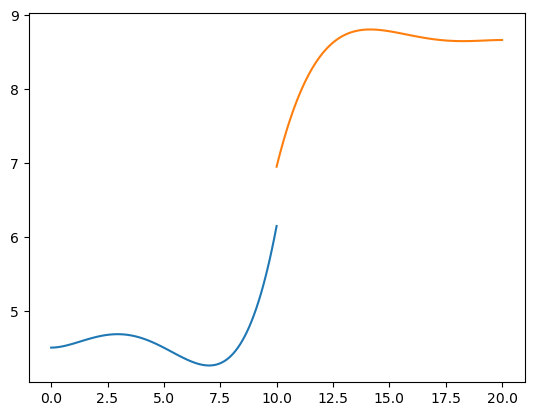

In [809]:
left = functions.left_thermal
right = functions.right_thermal
x1 = np.linspace(0,10,100)
x2 = np.linspace(10,20,100)

plt.plot(x1,left(x1))
plt.plot(x2,right(x2))

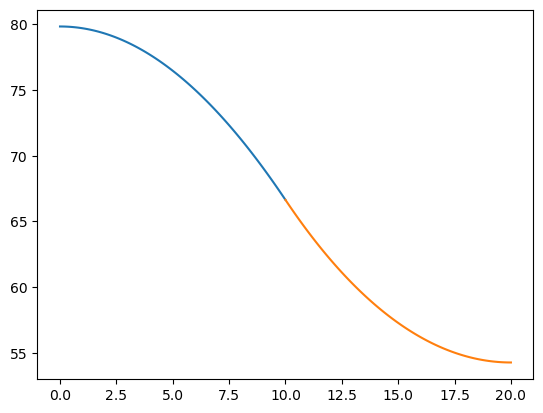

In [810]:
left = functions.left_fast
right = functions.right_fast

plt.plot(x1,left(x1))
plt.plot(x2,right(x2))